In [6]:
import numpy as np
import sys

sys.path.append('../../')

from src.client.AudioClient import AudioClient
from src.service.ModelService import Model

from scipy.optimize import curve_fit
from pylab import *


import pandas as pd


In [2]:
audio_client = AudioClient()
model = Model(audio_client, 45)

t = 0
q = np.load("Twinkle_Recording.npy")[:, 32:]
counts = []
tempos = []

tempo = model.score.tempo

while tempo < 320:
    count = 0

    while t < len(q[0]):
        obs = q[:, t]
        current_state, prob = model.next_observation(obs)
        t += 1

        if (current_state[0] == 2):
            count += 1

    print(tempo, count)

    counts.append(count)
    tempos.append(tempo)
    tempo += 5
    t = 0
    del model
    model = Model(audio_client, tempo)
    model.score.tempo = tempo

print(counts)
print(tempos)

45 39
50 39
55 39
60 39
65 39
70 39
75 39
80 39
85 38
90 34
95 31
100 27
105 25
110 22
115 20
120 18
125 17
130 15
135 14
140 13
145 12
150 11
155 10
160 10
165 9
170 8
175 8
180 7
185 7
190 7
195 6
200 6
205 5
210 5
215 5
220 5
225 4
230 4
235 4
240 4
245 4
250 3
255 3
260 3
265 3
270 3
275 3
280 3
285 3
290 2
295 2
300 2
305 2
310 2
315 2
[39, 39, 39, 39, 39, 39, 39, 39, 38, 34, 31, 27, 25, 22, 20, 18, 17, 15, 14, 13, 12, 11, 10, 10, 9, 8, 8, 7, 7, 7, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2]
[45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315]


[5.71525910e+01 6.18936072e+01 2.13834509e-02 2.32707859e+00]


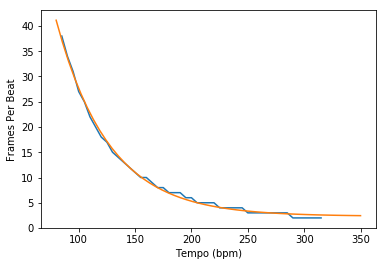

In [23]:
# https://stackoverflow.com/a/21421121

# Put Data into Dataframe
df = pd.DataFrame(list(zip(tempos[8:], counts[8:])), 
               columns =['Tempo', 'Frames Per Beat'])

# Exponential Function
def func(x, a, b, c, d):
    return a*np.exp(-c*(x-b))+d

x = df["Tempo"]
y = df["Frames Per Beat"]

# Fit parameters a,b,c,d
args, _ = curve_fit(func, x, y, [100,400,0.001,0])
print(args)

# Plot against observed values
plot(x,y)
x=linspace(80, 350)
plot(x,func(x,*args))
xlabel("Tempo (bpm)")
ylabel("Frames Per Beat")
show()

In [24]:
def inv_func(y, a, b, c, d):
    return (np.log((y - d)/(a)) / (-c)) + b

print(inv_func(9.5, *args))

158.95051899917462


We want a function that, given desired current tempo, produces the correct $a_{0,0}^i$ that produces the desired frames per beat.

Given a tempo and recording speed, we can calculate how many frames a beat is supposed to last. From basic tests, my computer / the current implementation records at around 9.5 frames a second or 570 frames per minute

By fitting the curve of score notated tempo to observed beat duration, we have a function that given a tempo, outputs the frames per beat that will actually occur in the system. It comes in the form

$$f(x) = ae^{-c(x-b)} + d$$

We can take the inverse of this function 

$$x = \frac{ln\left(\frac{y-d}{a}\right)}{-c} + b$$

Which gives us a function that given how many frames a beat is supposed to last, returns an approximation for the tempo for the system.

With this, we can simply calculate the correct $a_{0,0}^i$, that will make a beat last the desired duration.

$$a_{0,0}^i = 1 - \frac{1}{\frac{s}{x}}$$ 

where $s$ is the recording speed in frames per beat, and $x$ is the system tempo calculated from earlier.

